<a href="https://colab.research.google.com/github/alimoradi296/DeepLearning/blob/main/PixelCNNMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMPORT LIBRARIES

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.activations import relu
from tensorflow.keras import Sequential

import tensorflow_datasets as tfds

import numpy as np
import matplotlib.pyplot as plt



#LOAD MNIST DATASET

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to ~/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
The old signature is deprecated and will be removed. Please change your call to `tfds.show_examples(ds, info)`


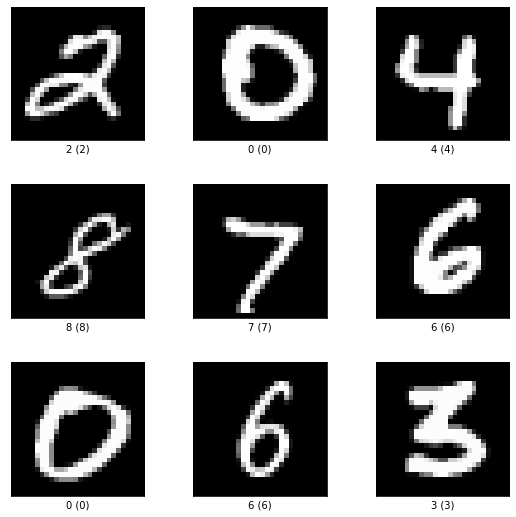

In [2]:
(ds_train,ds_test),ds_info=tfds.load('mnist',
                                     split=['test','test'],
                                     shuffle_files=True,
                                     as_supervised=True,
                                     with_info=True)
fig=tfds.show_examples(ds_info,ds_train)

#change image type to binary 0 or 1
def binarize(image,label):
  image=tf.cast(image,tf.float32)
  print(image)
  image=tf.math.round(image/255.)
  print(image)
  tf.cast(image,tf.int32)
  return image,tf.cast(image,tf.int32)




In [3]:
import pprint

In [4]:
print(ds_info)

tfds.core.DatasetInfo(
    name='mnist',
    full_name='mnist/3.0.1',
    description="""
    The MNIST database of handwritten digits.
    """,
    homepage='http://yann.lecun.com/exdb/mnist/',
    data_path='~/tensorflow_datasets/mnist/3.0.1',
    file_format=tfrecord,
    download_size=11.06 MiB,
    dataset_size=21.00 MiB,
    features=FeaturesDict({
        'image': Image(shape=(28, 28, 1), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=60000, num_shards=1>,
    },
    citation="""@article{lecun2010mnist,
      title={MNIST handwritten digit database},
      author={LeCun, Yann and Cortes, Corinna and Burges, CJ},
      journal={ATT Labs [Online]. Available: http://yann.lecun.com/exdb/mnist},
      volume={2},
      year={2010}
    }""",
)


In [5]:

print(ds_train)
ds_train=ds_train.map(binarize)
print(ds_train)
ds_train=ds_train.cache() # put data set into memory
print(ds_train)
ds_train=ds_train.shuffle(ds_info.splits['train'].num_examples)
print(ds_train)
ds_train=ds_train.batch(64)
print(ds_train)
ds_test=ds_test.map(binarize).batch(64).cache().prefetch(64)



<PrefetchDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>
Tensor("Cast:0", shape=(28, 28, 1), dtype=float32)
Tensor("Round:0", shape=(28, 28, 1), dtype=float32)
<MapDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(28, 28, 1), dtype=tf.int32, name=None))>
<CacheDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(28, 28, 1), dtype=tf.int32, name=None))>
<ShuffleDataset element_spec=(TensorSpec(shape=(28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(28, 28, 1), dtype=tf.int32, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 28, 28, 1), dtype=tf.int32, name=None))>
Tensor("Cast:0", shape=(28, 28, 1), dtype=float32)
Tensor("Round:0", shape=(28, 28, 1), dtype=float32)


#CREATE CUSTOM LAYERS AND PIXELCNN

In [6]:
class MaskedConv2D(layers.Layer):
    def __init__(self, mask_type, kernel=5, filters=1):
        super(MaskedConv2D, self).__init__()
        self.kernel = kernel
        self.filters = filters
        self.mask_type = mask_type
        
    def build(self, input_shape):

        self.w = self.add_weight(shape=[self.kernel,
                                        self.kernel,
                                        input_shape[-1],
                                        self.filters],
                                initializer='glorot_normal',
                                trainable=True)
        
        self.b = self.add_weight(shape=(self.filters,),
                                initializer='zeros',
                                trainable=True)
        # Create Mask 
        mask = np.ones(self.kernel**2, dtype=np.float32)
        center = len(mask)//2
        mask[center+1:] = 0
        if self.mask_type == 'A':
            mask[center] = 0
            
        mask = mask.reshape((self.kernel, self.kernel, 1, 1))
        
        self.mask = tf.constant(mask, dtype='float32')
        
    def call(self, inputs):
        # mask the convolution
        masked_w = tf.math.multiply(self.w, self.mask)

        # perform conv2d using low level API
        output = tf.nn.conv2d(inputs, masked_w, 1, "SAME") + self.b
        
        return tf.nn.relu(output)
    
class ResidualBlock(layers.Layer):
    def __init__(self, h=32):
        super(ResidualBlock, self).__init__()

        self.forward = Sequential([MaskedConv2D('B', kernel=1, filters=h),
                                   MaskedConv2D('B', kernel=3, filters=h),
                                   MaskedConv2D('B', kernel=1, filters=2*h)])         
    def call(self, inputs):
        x = self.forward(inputs)
        return x + inputs
    
def SimplePixelCnn(hidden_features=64, 
                   output_features=64, 
                   resblocks_num=7):

    inputs  = layers.Input(shape=[28,28,1])
    x = inputs
    
    x = MaskedConv2D('A',kernel=7, filters=2*hidden_features)(x)

    for _ in range(resblocks_num):
        x = ResidualBlock(hidden_features)(x)
        
    x = layers.Conv2D(output_features, (1,1), padding='same', activation='relu')(x)    
    x = layers.Conv2D(1, (1,1), padding='same', activation='sigmoid')(x)
            
    return tf.keras.Model(inputs

=inputs, outputs=x, name='PixelCnn')

pixel_cnn = SimplePixelCnn()
pixel_cnn.summary()



Model: "PixelCnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 masked_conv2d (MaskedConv2D  (None, 28, 28, 128)      6400      
 )                                                               
                                                                 
 residual_block (ResidualBlo  (None, 28, 28, 128)      53504     
 ck)                                                             
                                                                 
 residual_block_1 (ResidualB  (None, 28, 28, 128)      53504     
 lock)                                                           
                                                                 
 residual_block_2 (ResidualB  (None, 28, 28, 128)      53504     
 lock)                                                    

#TRAIN


In [7]:
pixel_cnn.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
    metrics=[ tf.keras.losses.BinaryCrossentropy()]
)

pixel_cnn.fit(ds_train,epochs=50,validation_data=ds_test)

Epoch 1/50
157/157 [==============================] - 27s 92ms/step - loss: 0.1513 - binary_crossentropy: 0.1511 - val_loss: 0.1114 - val_binary_crossentropy: 0.1114
Epoch 2/50
157/157 [==============================] - 14s 89ms/step - loss: 0.1029 - binary_crossentropy: 0.1029 - val_loss: 0.1147 - val_binary_crossentropy: 0.1147
Epoch 3/50
157/157 [==============================] - 14s 91ms/step - loss: 0.0979 - binary_crossentropy: 0.0979 - val_loss: 0.0947 - val_binary_crossentropy: 0.0947
Epoch 4/50
157/157 [==============================] - 14s 90ms/step - loss: 0.0942 - binary_crossentropy: 0.0942 - val_loss: 0.0916 - val_binary_crossentropy: 0.0916
Epoch 5/50
157/157 [==============================] - 14s 91ms/step - loss: 0.0920 - binary_crossentropy: 0.0920 - val_loss: 0.0924 - val_binary_crossentropy: 0.0924
Epoch 6/50
157/157 [==============================] - 14s 91ms/step - loss: 0.0907 - binary_crossentropy: 0.0906 - val_loss: 0.0898 - val_binary_crossentropy: 0.0898
Epoc

In [9]:
grid_row = 4
grid_col = 4
batch = grid_row * grid_col
h = w = 28
images = np.ones((batch,h,w,1), dtype=np.float32)
print(images.shape)

(16, 28, 28, 1)


In [10]:

for row in range(h):

    for col in range(w):

        prob = pixel_cnn.predict(images)[:,row,col,0]

        pixel_samples = tf.random.categorical(tf.math.log(np.stack([1-prob, prob],1)), 1)

        images[:,row,col,0] = tf.reshape(pixel_samples,[batch])



1/1 [==============================] - 0s 17ms/step


<ipython-input-11-b54490f8bb25>:10: MatplotlibDeprecationWarning: The 'renderer' parameter of tight_layout() is deprecated since Matplotlib 3.2 and will be removed two minor releases later.  If any parameter follows 'renderer', they should be pass as keyword, not positionally.
  f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)


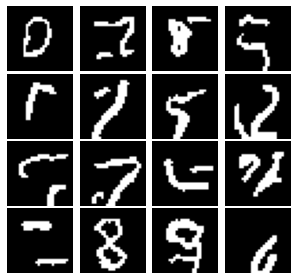

In [11]:
# Display
f, axarr = plt.subplots(grid_row, grid_col, figsize=(grid_col*1.1,grid_row))

i = 0
for row in range(grid_row):
    for col in range(grid_col):
        axarr[row,col].imshow(images[i,:,:,0], cmap='gray')
        axarr[row,col].axis('off')
        i += 1
f.tight_layout(0.1, h_pad=0.2, w_pad=0.1)        
plt.show()
